<a href="https://colab.research.google.com/github/Amarantine-xiv/Another-FF14-Combat-Sim/blob/main/CombatSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 Amarantine Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [101]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from dataclasses import dataclass, InitVar, field
import heapq
from enum import Enum

In [102]:
#@title Define stat tiers and class modifiers. Misc functions. ###
def get_dh_stat(dh_stat):
  return np.floor(550*(dh_stat-400)/1900)/1000
  
def get_gcd_time(speed_stat, base_gcd_time):
  return (np.floor((1000*base_gcd_time)*(1000+np.ceil(130*(400-speed_stat)/1900))/10000)/100)

def get_auto_delay(base_weapon_delay, buffs, debuffs):
  return base_weapon_delay*(buffs.haste_time_reduction + debuffs.haste_time_reduction)      

def get_crit_stats(crit_stat):
  crit_rate = (np.floor(200*(crit_stat-400)/1900)+50)/1000
  crit_bonus = (np.floor(200*(crit_stat-400)/1900)+400)/1000
  return crit_rate, crit_bonus

# from Hint's repo, https://github.com/hintxiv/reassemble
def fAP(main_stat, isTank= False):
  if isTank:
    return np.floor(156*(main_stat-390)/390) + 100
  return np.floor(195*(main_stat-390)/390) + 100

def fTnc(tenacity):
  return (1000+np.floor(100*(tenacity-400)/1900))/1000

def fAuto(wd, weapon_delay, job_mod):
  return np.floor(np.floor(390 * job_mod / 1000 + wd) * (weapon_delay / 3))

# from Hint's repo, https://github.com/hintxiv/reassemble
def fDet(det_stat):
  return np.floor(140*(det_stat-390)/1900) + 1000

# for taking into account bonuses from guranteed dhs.
def fDetDH(det_stat, dh_stat):
  return np.floor(140*(det_stat-390)/1900) + np.floor(140*(dh_stat-390)/1900) + 1000

# from Hint's repo, https://github.com/hintxiv/reassemble
def fWD(wd, job_mod):
  return np.floor(390*job_mod/1000 + wd)

# from Hint's repo, https://github.com/hintxiv/reassemble
def fSpd(speed_stat):
  return np.floor(130 * (speed_stat - 400) / 1900 + 1000)

# See https://www.akhmorning.com/allagan-studies/modifiers/ . Each class' class num is its main attribute #.
JOB_MODS = {'SCH': 115, 'WAR': 105, 'SAM': 112, 'RPR': 115}

def compute_trait_dmg_add(job_class):
  if job_class == 'SCH':
    return 0.30  
  else:
    return 0

def isCaster(job_class):
  return job_class in ['RDM', 'BLM', 'BLU', 'SMN']

def isHealer(job_class):
  return job_class in ['SCH', 'WHM', 'AST', 'SGE']

def isTank(job_class):
  return job_class in ['GNB', 'WAR', 'PLD', 'DRK']


In [103]:
#@title Stats, ProcessedStats, StatusEffects
@dataclass(frozen=True)
class Stats():
  wd: float
  weapon_delay: float
  main_stat: float
  det_stat: float
  dh_stat: float
  crit_stat: float
  speed_stat: float
  job_class: str  
  tenacity: float = None
  num_roles_in_party: float = 5
  healer_or_caster_strength: float= None
  def __post_init__(self):
     object.__setattr__(self, 'job_mod', JOB_MODS[self.job_class])
     object.__setattr__(self, 'trait_dmg_add', compute_trait_dmg_add(self.job_class))

@dataclass(frozen=True)
class ProcessedStats():
  stats: InitVar[Stats]

  def __post_init__(self, stats):
    object.__setattr__(self, 'stats', stats)
    (crit_rate, crit_bonus) = get_crit_stats(stats.crit_stat)
    object.__setattr__(self, 'crit_rate', crit_rate)
    object.__setattr__(self, 'crit_bonus', crit_bonus)
    object.__setattr__(self, 'det_bonus', fDet(stats.det_stat))
    object.__setattr__(self, 'dh_rate', get_dh_stat(stats.dh_stat))

  def  __str__(self):
    res = 'Crit rate:' + str(self.crit_rate) + '\n'
    res += 'Crit bonus:' + str(self.crit_bonus) + '\n'
    res += '\nDet bonus:' + str(self.det_bonus) + '\n'
    res += '\nDH Rate:' + str(self.dh_rate)
    res += '\nDot Multiplier:' + str(self.dot_multiplier)    
    return res  

@dataclass(frozen=False)
class StatusEffects:  
  damage_mult: float = 1
  crit_rate_add: float = 0
  dh_rate_add: float = 0
  main_stat_add: float = 0
  haste_time_reduction: float = 0
  active: dict = field(default_factory=dict)
    
  def __str__(self):
    res = 'damage_mult: ' + str(self.damage_mult) + '\n'
    res += 'crit_rate_add: ' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add: ' + str(self.dh_rate_add) + '\n'
    res += 'main_stat_add: ' + str(self.main_stat_add) + '\n'
    res += 'haste_time_reduction: ' + str(self.haste_time_reduction)
    return res

  def apply_augment(self, other):
    self.main_stat_add += other.main_stat_add
    self.crit_rate_add += other.crit_rate_add
    self.dh_rate_add += other.dh_rate_add
    self.haste_time_reduction += other.haste_time_reduction
    self.damage_mult *= other.damage_mult      
  
  def unapply_augment(self, other):
    self.main_stat_add -= other.main_stat_add
    self.crit_rate_add -= other.crit_rate_add
    self.dh_rate_add -= other.dh_rate_add
    self.haste_time_reduction -= other.haste_time_reduction
    self.damage_mult /= other.damage_mult

In [104]:
#@title DamageClass, ForcedCritOrDH, CastSpec, DamageSpec, SkillStatusEffectSpec, Skill
class DamageClass(Enum):
    UNKNOWN = 0
    DIRECT = 1
    DOT = 2
    AUTO = 3

class ForcedCritOrDH(Enum):
  UNKNOWN = 0
  DEFAULT = 1
  FORCE_NO = 2
  FORCE_YES = 3
  FORCE_YES_WITH_NO_DMG_BONUS = 4

@dataclass(frozen=True)
class CastSpec:
  base_cast_time: float = 0
  base_recast_time: float = 1
  is_GCD: bool = True
  animation_lock: float = 0.65

@dataclass(frozen=True)
class DamageSpec:
  potency: float = None
  damage_class: DamageClass = DamageClass.DIRECT
  guaranteed_crit: ForcedCritOrDH = None
  guaranteed_dh: ForcedCritOrDH = None
  use_trait_buff: bool = True

  # the fields below are used if the damage is a dot
  dot_duration : float = None
  dot_tick_name : str = ""
  snapshots_buffs: bool = False
  snapshots_debuffs: bool = False

  def  __str__(self):
    res = 'potency:' + str(self.potency) + '\n'
    res += 'guaranteed_crit:' + str(self.guaranteed_crit) + '\n'
    res += 'guaranteed_dh:' + str(self.guaranteed_dh) + '\n'
    res += 'use_trait_buff:' + str(self.use_trait_buff) + '\n'
    res += 'dot_duration:' + str(self.dot_duration) + '\n'
    res += 'dot_tick_name:' + str(self.dot_tick_name) + '\n'
    res += 'snapshots_buffs:' + str(self.snapshots_buffs)  + '\n'
    res += 'snapshots_debuffs:' + str(self.snapshots_debuffs)  + '\n'
    return res 

@dataclass(frozen=True)
class SkillStatusEffectSpec:
  duration: float
  max_duration: float = None
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  main_stat_add: float= 0
  damage_mult: float= 1
  haste_time_reduction: float= 1

  def __post_init__(self):
    if self.max_duration is None:
      object.__setattr__(self, 'max_duration', self.duration)  

  def  __str__(self):
    res = 'main_stat_add:' + str(self.main_stat_add) + '\n'
    res += 'crit_rate_add:' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add:' + str(self.dh_rate_add) + '\n'
    res += 'damage_mult:' + str(self.damage_mult) + '\n'
    res += 'duration:' + str(self.duration) + '\n'
    res += 'max_duration:' + str(self.max_duration) + '\n'
    res += 'haste_time_reduction:' + str(self.haste_time_reduction)
    return res 

@dataclass(frozen=True)
class Skill:
  name: str
  damage_spec: DamageSpec = None
  buff_spec: SkillStatusEffectSpec = None
  debuff_spec: SkillStatusEffectSpec = None
  cast_spec: CastSpec = None  
  follow_up_skills : tuple = () # a tuple of tuples. Each element in the tuple is of the format (time_delay, skill_name).

  def __gt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name > other.name
  def __lt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name < other.name
  def __eq__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    self.name == other.name

  def __hash__(self):
    return hash(self.name)

  def  __str__(self):
    res = 'name:' + str(self.name) + '\n'
    if self.damage_spec is None:
      res += '---No damage spec---\n'
    else:
      res += str(self.damage_spec)
    if self.buff_spec is None:
      res += '---No skill buff spec---\n'
    else:
      res += str(self.buff_spec)
    if self.follow_up_skills is not None:
      for i in range(0, len(self.follow_up_skills)):
        res += "Follow up skill " + str(i) + ". Delay: " + str(self.follow_up_skills[i][0]) + '\n'
        res += str(self.follow_up_skills[i][0].name) + '\n'
    return res

class ComputeDamage:  
  @staticmethod
  def compute_direct_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    stats = processed_stats.stats
    is_tank = isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    # from HINT
    potency = skill.damage_spec.potency
    ap = fAP(main_stat, is_tank)
    wd = fWD(stats.wd, stats.job_mod)
    det = processed_stats.det_bonus
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    # TODO: move to readme or somewhere better than this.
    # 1) main stat changed by pots/party buffs (# of roles)
    # 2) potency and fAP are taken into account
    # 3) det (and potentially dh if autocrit) is taken into account
    # 4) tnc is taken into account, if applicable (tanks)
    # 5) sps/sks is taken into account, if applicable (eg, dots)
    # 6) weapon damage and weapon delay are taken account, if applicable
    # 7) apply the +1 for dots
    # 8) apply guaranteed crit bonus using crit rate up, if applicable
    # 9) apply guaranteed direct hit bonus dh up, if applicable
    # 10) apply +-5% damage variance (on ALL sources of damage, direct, auto, dot)
    # 11) crit/direct hit multipliers are taken into account, if applicable. NO FLOORING IS DONE HERE (but i can if you think i should)
    # 12) traits are taken into account, if applicable
    # 13) each straight up damage buff/enemy increased damage taken is taken into account multiplicatively. NO FLOORING IS DONE BETWEEN APPLYING BUFFS

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))    
    base_damage = np.floor(base_damage*wd)       

    # take into account crit rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular crit roll, but we do it here for simplicity.
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES:
      crit_rate_bonus = buffs.crit_rate_add + debuffs.crit_rate_add
      base_damage += np.floor(base_damage*crit_rate_bonus*processed_stats.crit_bonus)

    # take into account dh rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular dh roll, but we do it here for simplicity.
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      dh_rate_bonus = buffs.dh_rate_add + debuffs.dh_rate_add
      base_damage += np.floor(base_damage*dh_rate_bonus*0.25)

    return base_damage

  @staticmethod
  def compute_dot_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    # Q: what is the dot damage formula for tanks with tenacity?

    stats = processed_stats.stats
    is_tank = isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    potency = skill.damage_spec.potency
    spd = fSpd(stats.speed_stat)
    ap = fAP(main_stat, is_tank)
    det = processed_stats.det_bonus
    wd = fWD(stats.wd, stats.job_mod)
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*wd)
    base_damage = base_damage + 1

    # take into account crit rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular crit roll, but we do it here for simplicity.
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES:
      crit_rate_bonus = buffs.crit_rate_add + debuffs.crit_rate_add
      base_damage += np.floor(base_damage*crit_rate_bonus*processed_stats.crit_bonus)

    # take into account dh rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular dh roll, but we do it here for simplicity.
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      dh_rate_bonus = buffs.dh_rate_add + debuffs.dh_rate_add
      base_damage += np.floor(base_damage*dh_rate_bonus*0.25)

    return base_damage

  @staticmethod
  def compute_auto_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    stats = processed_stats.stats
    if (isHealer(stats.job_class) or isCaster(stats.job_class)):
      # for healers/casters, the statu used to compute autos is strength, not main stat. So use that and pots and party bonus doesn't affect it
      if stats.healer_or_caster_strength is None:
        raise RuntimeError('Cannot compute auto attack damage for healer/caster unless healer_or_caster_strength stat is specified.') 
      auto_main_stat = stats.healer_or_caster_strength      
    else:
      # for non-healers/casters, the stat used to compute autos is our main stat, and we get all the buffs/bonuses on it
      auto_main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
      auto_main_stat = np.floor(auto_main_stat*(1+0.01*stats.num_roles_in_party))
    
    is_tank = isTank(stats.job_class)
    potency = skill.damage_spec.potency
    spd = fSpd(stats.speed_stat)
    ap = fAP(auto_main_stat, is_tank)
    det = processed_stats.det_bonus
    weapon_delay = stats.weapon_delay
    auto = fAuto(stats.wd, weapon_delay, stats.job_mod)
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*auto)

    # take into account crit rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular crit roll, but we do it here for simplicity.
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES:
      crit_rate_bonus = buffs.crit_rate_add + debuffs.crit_rate_add
      base_damage += np.floor(base_damage*crit_rate_bonus*processed_stats.crit_bonus)

    # take into account dh rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular dh roll, but we do it here for simplicity.
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      dh_rate_bonus = buffs.dh_rate_add + debuffs.dh_rate_add
      base_damage += np.floor(base_damage*dh_rate_bonus*0.25)

    return base_damage

  @staticmethod
  def get_base_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec is None:
      return None    
    
    if (skill.damage_spec.damage_class == DamageClass.DIRECT):
        base_damage = ComputeDamage.compute_direct_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (skill.damage_spec.damage_class == DamageClass.DOT):
        base_damage = ComputeDamage.compute_dot_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (skill.damage_spec.damage_class == DamageClass.AUTO):
        base_damage = ComputeDamage.compute_auto_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    else:
        base_damage = None
    return base_damage

In [105]:
#@title All skill specifications

# Convenience objects. These are all immutable so we can use them safely in all skills if we like
HEALER_GCD= CastSpec(base_cast_time=1.5, base_recast_time=2.5, is_GCD=True)
WAR_GCD= CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=True)
SAM_GCD= CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=True)

class SkillLibrary:
  def __init__(self):
    self._skills = {}
    self._dot_skills = {}
  
  def add_job_class(self, job_class):
    self._skills[job_class] = {}
    self._dot_skills[job_class] = set()
  
  def add_skill(self, job_class, name, damage_spec= None, buff_spec= None, debuff_spec= None, cast_spec= None, follow_up_skills = ()):
    self._skills[job_class][name] = Skill(name,
                                          damage_spec=damage_spec,
                                          buff_spec=buff_spec,
                                          debuff_spec=debuff_spec,
                                          cast_spec=cast_spec,
                                          follow_up_skills=follow_up_skills)

    if damage_spec is not None and damage_spec.dot_duration is not None:
      self._dot_skills[job_class].add(name)

  def get_skill(self, job_class, name):
    return self._skills[job_class][name]

  def is_dot_skill(self, job_class, name):
    return name in self._dot_skills[job_class]

  def is_auto_skill(self, job_class, name):
    return name == 'Auto'

skill_library = SkillLibrary()
skill_library.add_job_class('General')
skill_library.add_skill('General', 'Pot', buff_spec = SkillStatusEffectSpec(duration= 30, main_stat_add=223), cast_spec=CastSpec(base_cast_time=0, base_recast_time=270, is_GCD=False, animation_lock=1.3))

skill_library.add_job_class('SCH')
skill_library.add_skill('SCH', 'Auto', damage_spec=DamageSpec(potency=80, damage_class=DamageClass.AUTO, use_trait_buff= False), cast_spec=CastSpec(base_cast_time=0, base_recast_time=None, is_GCD=0, animation_lock = 0))
skill_library.add_skill('SCH', 'Broil', damage_spec=DamageSpec(potency=295), cast_spec=HEALER_GCD)
skill_library.add_skill('SCH', 'EnergyDrain', damage_spec=DamageSpec(potency=100), cast_spec=CastSpec(base_cast_time=0, base_recast_time=1, is_GCD=False))
skill_library.add_skill('SCH', 'ArtOfWar', damage_spec=DamageSpec(potency=165), cast_spec=CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=False))
skill_library.add_skill('SCH', 'ChainStrategem', debuff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.10), cast_spec=CastSpec(base_cast_time=0, base_recast_time=120, is_GCD=False))
skill_library.add_skill('SCH', '_Biolysis_dot', damage_spec=DamageSpec(potency=70, damage_class=DamageClass.DOT), cast_spec=CastSpec(base_cast_time=0, base_recast_time=3, is_GCD=0, animation_lock=0))
skill_library.add_skill('SCH', 'Biolysis', damage_spec=DamageSpec(damage_class=None, dot_duration=30, dot_tick_name= '_Biolysis_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=True))

skill_library.add_job_class('WAR')
skill_library.add_skill('WAR', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, use_trait_buff= False), cast_spec=CastSpec(base_cast_time=0, base_recast_time=None, is_GCD=0, animation_lock = 0))
skill_library.add_skill('WAR', 'HeavySwing', damage_spec=DamageSpec(potency=200), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Maim', damage_spec=DamageSpec(potency=300), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'StormsPath', damage_spec=DamageSpec(potency=430), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'StormsEye', damage_spec=DamageSpec(potency=430), buff_spec= SkillStatusEffectSpec(duration=30, max_duration=60, damage_mult=1.10), cast_spec=WAR_GCD)

skill_library.add_skill('WAR', 'Upheaval', damage_spec=DamageSpec(potency=370), cast_spec=CastSpec(base_cast_time=0, base_recast_time=30, is_GCD=False))
skill_library.add_skill('WAR', 'Onslaught', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(base_cast_time=0, base_recast_time=1, is_GCD=False))
skill_library.add_skill('WAR', 'FellCleave', damage_spec=DamageSpec(potency=490), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'PrimalRend', damage_spec=DamageSpec(potency=700), cast_spec=CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=True, animation_lock=1.3))
skill_library.add_skill('WAR', 'InnerChaos', damage_spec=DamageSpec(potency=650, guaranteed_crit=ForcedCritOrDH.FORCE_YES,  guaranteed_dh=ForcedCritOrDH.FORCE_YES), cast_spec=CastSpec(base_cast_time=0, base_recast_time=2.5, is_GCD=True))
skill_library.add_skill('WAR', 'Tomahawk', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Overpower', damage_spec=DamageSpec(potency=110), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'MythrilTempest', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Orogeny', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(base_cast_time=0, base_recast_time=30, is_GCD=False))
skill_library.add_skill('WAR', 'Decimate', damage_spec=DamageSpec(potency=200), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_Maim_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_StormsPath_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_StormsEye_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_MythrilTempest', damage_spec=DamageSpec(potency=100), cast_spec=WAR_GCD)

skill_library.add_job_class('DNC')
skill_library.add_skill('DNC', 'Devilment', buff_spec= SkillStatusEffectSpec(duration=20, crit_rate_add=0.2, dh_rate_add=0.2), cast_spec=CastSpec(base_cast_time=0, base_recast_time=120, is_GCD=False))

skill_library.add_job_class('DRG')
skill_library.add_skill('DRG', 'BattleLitany', buff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.1), cast_spec=CastSpec(base_cast_time=0, base_recast_time=120, is_GCD=False))

skill_library.add_job_class('RPR')
skill_library.add_skill('RPR', 'ArcaneCircle', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.03), cast_spec=CastSpec(base_cast_time=0, base_recast_time=120, is_GCD=False))

skill_library.add_job_class('RDM')
skill_library.add_skill('RDM', 'Embolden', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05), cast_spec=CastSpec(base_cast_time=0, base_recast_time=120, is_GCD=False))

skill_library.add_job_class('SAM')
skill_library.add_skill('SAM', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, use_trait_buff= False), cast_spec=CastSpec(base_cast_time=0, base_recast_time=None, is_GCD=0, animation_lock = 0))
skill_library.add_skill('SAM', 'Hakaze', damage_spec=DamageSpec(potency=200), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Shifu', damage_spec=DamageSpec(potency=280), buff_spec=SkillStatusEffectSpec(duration=40, haste_time_reduction=0.13), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Jinpu', damage_spec=DamageSpec(potency=280), buff_spec= SkillStatusEffectSpec(duration=40, damage_mult=1.13), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Enpi', damage_spec=DamageSpec(potency=260), cast_spec=SAM_GCD)

skill_library.add_skill('SAM', 'Shifu_noCombo', damage_spec=DamageSpec(potency=280), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', '_Jinpu_noCombo', damage_spec=DamageSpec(potency=120), buff_spec= SkillStatusEffectSpec(duration=40, damage_mult=1.13), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', '_Enpi_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=SAM_GCD)


In [106]:
#@title DpsTracker

class DpsTracker():
  def __init__(self):    
    self.base_damage=np.zeros((5000,1))
    self.crit_rate=np.zeros((5000,1))
    self.crit_bonus=np.zeros((5000,1))
    self.dh_rate = np.zeros((5000,1))
    self.trait_mask = np.zeros((5000,1))
    self.dmg_buff_mult = np.ones((5000,1))
    self.it = 0
    self.isFinalized = False

  def add_damage(self, base_damage, crit_rate, crit_bonus, dh_rate, trait_mask, dmg_buff_mult):
    if not self.isFinalized:
      self.base_damage[self.it] = base_damage
      self.crit_rate[self.it] = crit_rate
      self.crit_bonus[self.it] = crit_bonus
      self.dh_rate[self.it] = dh_rate
      self.trait_mask[self.it] = trait_mask
      self.dmg_buff_mult[self.it] = dmg_buff_mult
      self.it +=1
    else:
      raise RuntimeError('DPS tracker is finalized. Cannot add damage instances.')

  def finalize(self):
    self.base_damage = self.base_damage[0:self.it]
    self.crit_rate = self.crit_rate[0:self.it]
    self.crit_bonus = self.crit_bonus[0:self.it]
    self.dh_rate = self.dh_rate[0:self.it]
    self.trait_mask = self.trait_mask[0:self.it]
    self.dmg_buff_mult = self.dmg_buff_mult[0:self.it]
    self.isFinalized = True    


In [107]:
#@title Rotation

class RotationBuilder():
  def __init__(self, stats, skill_library):    
    self._q = []
    self._stats = stats    
    self._skill_library = skill_library
    self._dot_skills = {}
    self._is_built = False

  @staticmethod
  def _errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec:
      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed crit should only be used for DIRECT damage to work. If you are seeing this msg, make sure you know what you are doing with guaranteed crit.')

      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_dh is ForcedCritOrDH.FORCE_YES or guaranteed_dh is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed dh should only be used for DIRECT damage to work. If you are seeing this msg, make sure you know what you are doing with guaranteed dh.')
        
      if skill.damage_spec.guaranteed_crit is not None and guaranteed_crit is not None:
        raise RuntimeError('Cannot specify guaranteed crit in skill spec and on this particular damage instance. Only one or the other should be specified.')
      if skill.damage_spec.guaranteed_dh is not None and guaranteed_dh is not None:
        raise RuntimeError('Cannot specify guaranteed dh in skill spec and on this particular damage instance. Only one or the other should be specified.')

  @staticmethod
  def _get_guaranteed_crit_dh(skill, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec:
      if skill.damage_spec.guaranteed_crit is not None:
        guaranteed_crit = skill.damage_spec.guaranteed_crit
      if skill.damage_spec.guaranteed_dh is not None:
        guaranteed_dh = skill.damage_spec.guaranteed_dh
      
    # neither the innate skill nor the adding of the skill specifies crit/dh. Default to the default behaviour.
    if guaranteed_crit is None:
      guaranteed_crit = ForcedCritOrDH.DEFAULT
    if guaranteed_dh is None:
      guaranteed_dh = ForcedCritOrDH.DEFAULT
    return guaranteed_crit, guaranteed_dh

  @staticmethod
  def _get_damage_snapshot_time(skill, t):        
    return t + max(skill.cast_spec.base_cast_time - 0.5, 0)
  
  def add_skill(self, t, name, job_class_to_use=None, snapshot_buffs=None, snapshot_debuffs=None, guaranteed_crit= None, guaranteed_dh= None):
    if job_class_to_use is None:
      job_class_to_use = self._stats.job_class

    skill = self._skill_library.get_skill(job_class_to_use, name)      
    RotationBuilder._errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh)
    guaranteed_crit, guaranteed_dh = RotationBuilder._get_guaranteed_crit_dh(skill, guaranteed_crit, guaranteed_dh)
    damage_snapshot_time = RotationBuilder._get_damage_snapshot_time(skill, t)  

    if self._skill_library.is_dot_skill(job_class_to_use, name):
      if(self._is_built):
        raise RuntimeError("Cannot add a dot skill after rotation is built. It will not be expanded to all dot ticks correctly.")

      if skill not in self._dot_skills:
        self._dot_skills[skill] = []
      # Dots never snapshot buffs/debuffs   
      self._dot_skills[skill].append((damage_snapshot_time, guaranteed_crit, guaranteed_dh))

    else:
      heapq.heappush(self._q, (damage_snapshot_time, skill, snapshot_buffs, snapshot_debuffs, guaranteed_crit, guaranteed_dh, [list(x) for x in skill.follow_up_skills]))

  def get_next_damage_instance(self):
    return heapq.heappop(self._q)

  def is_empty(self):    
    return len(self._q) == 0

  def _process_dot_skills(self):
    for skill in self._dot_skills:
      # add tombstone ending skill to signify the end of the fight.
      self._dot_skills[skill].append((np.Inf, None, None))
      self._dot_skills[skill].sort(key=lambda x: x[0])
      for i in range(0, len(self._dot_skills[skill])-1):
        # Note: guaranteed_crit, guaranteed_dh refer to the damage portion ON the application of the dot, not the dot part itself.
        dot_time, guaranteed_crit, guaranteed_dh = self._dot_skills[skill][i]
        next_dot_time = self._dot_skills[skill][i+1][0]
        curr_dot_duration = int(min(next_dot_time - dot_time, skill.damage_spec.dot_duration))
        
        follow_up_skills=[[delay, skill.damage_spec.dot_tick_name] for delay in range(0, curr_dot_duration,3)]
        heapq.heappush(self._q, (dot_time, skill, None, None, guaranteed_crit, guaranteed_dh, follow_up_skills))

  def print_rotation(self):
    for i in self._q:
      print('Time: {time}, Skill name: {skill_name}'.format(time=i[0], skill_name=i[1].name))

  def build(self):
    res = copy.deepcopy(self)
    res._process_dot_skills()
    res._is_built = True
    return res

In [108]:
#@title StatusEffectsTracker

class StatusEffectsTracker:
  def __init__(self, tracks_buffs, status_effects= None):
    self.tracks_buffs = tracks_buffs
    self.status_effects = StatusEffects() if status_effects is None else status_effects
        
  def _do_apply_status_effect(self, skill, status_effect_change_spec, t):
    if skill not in self.status_effects.active.keys():
      self.status_effects.active[skill] = t
      self.status_effects.apply_augment(status_effect_change_spec)
      
    self.status_effects.active[skill] = min(self.status_effects.active[skill] + status_effect_change_spec.duration,
                                            t + status_effect_change_spec.max_duration)

  def apply_status_effects(self, skill, t):
    if self.tracks_buffs:
      if skill.buff_spec is not None:
          self._do_apply_status_effect(skill, skill.buff_spec, t)
    else:
      if skill.debuff_spec is not None:
          self._do_apply_status_effect(skill, skill.debuff_spec, t)

  def _do_unapply_status_effect(self, skill, status_effect_change_spec, t):
      if skill not in self.status_effects.active.keys():
        raise RuntimeError('Error: attempting to unapply a status effect that is not currently active.')

      self.status_effects.unapply_augment(status_effect_change_spec)
      del self.status_effects.active[skill]
  
  def _do_unapply_all_expired_status_effects(self, t):
    active_skills = list(self.status_effects.active.keys())
    for skill in active_skills:
      is_expired = self.status_effects.active[skill] < t
      if is_expired:
        if self.tracks_buffs and skill.buff_spec is not None:
          self._do_unapply_status_effect(skill, skill.buff_spec, t)
        if (not self.tracks_buffs) and skill.debuff_spec is not None:
          self._do_unapply_status_effect(skill, skill.debuff_spec, t)

  def unapply_all_expired_status_effects(self, t):
    self._do_unapply_all_expired_status_effects(t)    

In [109]:
#@title Simulator
class Simulator:
  def __init__(self, stats, rotation, num_samples = 1000000, debug=False):
    self.stats = stats
    self.rotation = rotation
    self.num_samples = num_samples    
    self.buffs = StatusEffectsTracker(tracks_buffs=True)
    self.debuffs = StatusEffectsTracker(tracks_buffs=False)
    self.debug = debug

  def _compute_crit_rates_and_bonuses(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh):
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      crit_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      crit_rate = 0
    else:
      crit_rate = processed_stats.crit_rate + buffs_to_use.crit_rate_add + debuffs_to_use.crit_rate_add
    crit_bonus = processed_stats.crit_bonus

    if guaranteed_dh is ForcedCritOrDH.FORCE_YES or guaranteed_dh is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      dh_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      dh_rate = 0
    else:
      dh_rate = processed_stats.dh_rate + buffs_to_use.dh_rate_add + debuffs_to_use.dh_rate_add
    return (crit_rate, crit_bonus, dh_rate)
  
  def _update_rotation(self, snapshot_buffs, snapshot_debuffs, follow_up_skills, t):
    if follow_up_skills is not None:      
      for i in range (0, len(follow_up_skills)):
        delay, follow_up_skill_name = follow_up_skills[i]        
        self.rotation.add_skill(t+delay,follow_up_skill_name, snapshot_buffs=snapshot_buffs, snapshot_debuffs=snapshot_debuffs)

  def _unapply_all_expired_status_effects(self, time):
    self.buffs.unapply_all_expired_status_effects(time)
    self.debuffs.unapply_all_expired_status_effects(time)

  def _apply_status_effects(self, skill, time):
    self.buffs.apply_status_effects(skill, time)
    self.debuffs.apply_status_effects(skill, time)

  def simulate(self):
    processed_stats = ProcessedStats(self.stats)
    dps_tracker = DpsTracker()    
    
    while not self.rotation.is_empty():
      (time, skill, snapshot_buffs, snapshot_debuffs, guaranteed_crit, guaranteed_dh, follow_up_skills) = self.rotation.get_next_damage_instance()      
      self._unapply_all_expired_status_effects(time)      

      buffs_to_use = self.buffs.status_effects if snapshot_buffs is None else snapshot_buffs
      debuffs_to_use = self.debuffs.status_effects if snapshot_debuffs is None else snapshot_debuffs

      if self.debug:
        print('Time: {time}, Skill name: {skill_name}'.format(time=time, skill_name=skill.name))
        print("Buffs: ")
        print(buffs_to_use)
        print("Debuffs: ")
        print(debuffs_to_use)
          
      base_damage = ComputeDamage.get_base_damage(skill, processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)
      if base_damage is not None:  
        (crit_rate, crit_bonus, dh_rate) = Simulator._compute_crit_rates_and_bonuses(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)

        trait_mask = 1 if skill.damage_spec.use_trait_buff is True else 0
        dmg_buff_mult = buffs_to_use.damage_mult*debuffs_to_use.damage_mult

        dps_tracker.add_damage(base_damage, crit_rate, crit_bonus, dh_rate, trait_mask, dmg_buff_mult)      
            
      self._apply_status_effects(skill, time)
      
      snapshot_buffs = copy.deepcopy(self.buffs.status_effects) if (skill.damage_spec and skill.damage_spec.snapshots_buffs) else None
      snapshot_debuffs = copy.copy(self.debuffs.status_effects) if (skill.damage_spec and skill.damage_spec.snapshots_debuffs) else None
      self._update_rotation(snapshot_buffs, snapshot_debuffs, follow_up_skills, time)    

    dps_tracker.finalize()

    num_damage_instances = dps_tracker.base_damage.shape[0]
    total_damage = np.floor(dps_tracker.base_damage*(0.95+np.random.rand(num_damage_instances,self.num_samples)/10))
    total_damage += np.floor(np.multiply(total_damage, np.multiply(dps_tracker.crit_bonus, dps_tracker.crit_rate >= np.random.rand(num_damage_instances,self.num_samples))))
    total_damage += np.floor(np.multiply(total_damage, 0.25*(dps_tracker.dh_rate >= np.random.rand(num_damage_instances,self.num_samples))))
    total_damage += np.floor(np.multiply(total_damage, stats.trait_dmg_add*dps_tracker.trait_mask))
    total_damage = np.floor(np.multiply(total_damage, dps_tracker.dmg_buff_mult))
    total_damage = np.sum(total_damage,axis=0)
    return total_damage, dps_tracker

In [110]:
CLASS_TO_SIM = 'SCH_bio_test'

In [111]:
#@title SCH_bio_test sim
if CLASS_TO_SIM == 'SCH_bio_test':
  stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'SCH', healer_or_caster_strength=351)
  # stats = Stats(wd=126, weapon_delay=3.12, main_stat=2949, det_stat=1721, crit_stat=2387, dh_stat=1340, speed_stat=536, job_class = 'SCH')

  gcd_time=2.42
  rb= RotationBuilder(stats, skill_library)

  # rb.add_skill(0*gcd_time, 'Broil')
  # should return about 1146. just the broils
  # 3 bios: 1146, 2 bios: 1051, 1bio: 955
  rb.add_skill(0*gcd_time, 'Biolysis')
  rb.add_skill(1*gcd_time, 'Biolysis')
  rb.add_skill(2*gcd_time, 'Biolysis')
  #dots snapshot so this buff should have no effect
  rb.add_skill(3*gcd_time+0.6, 'ChainStrategem')
  fight_time = 13*gcd_time

In [112]:
#@title SCH sim

if CLASS_TO_SIM == 'SCH':
  stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'SCH', healer_or_caster_strength=351)
  # stats = Stats(wd=126, weapon_delay=3.12, main_stat=2949, det_stat=1721, crit_stat=2387, dh_stat=1340, speed_stat=536, job_class = 'SCH')

  gcd_time=2.42
  rb= RotationBuilder(stats, skill_library)

  # rb.add_skill(0*gcd_time, 'Broil')
  # should return about 1146. just the broils
  # 3 bios: 1146, 2 bios: 1051, 1bio: 955
  # rb.add_skill(0*gcd_time, 'Biolysis')
  # rb.add_skill(1*gcd_time, 'Biolysis')
  # rb.add_skill(2*gcd_time, 'Biolysis')

  ## Should return ~7500 average dps
  rb.add_skill(1*gcd_time+0.1, 'Auto')
  rb.add_skill(-2.5, 'Pot', 'General')
  rb.add_skill(1*gcd_time, 'Biolysis')
  rb.add_skill(0*gcd_time, 'Broil')
  rb.add_skill(2*gcd_time, 'Broil')
  rb.add_skill(3*gcd_time, 'Broil')
  rb.add_skill(3*gcd_time+0.6, 'ChainStrategem')
  rb.add_skill(3*gcd_time+1.2, 'EnergyDrain')
  rb.add_skill(4*gcd_time, 'Broil')
  rb.add_skill(4*gcd_time+0.6, 'EnergyDrain')
  rb.add_skill(5*gcd_time, 'Broil')
  rb.add_skill(5*gcd_time+0.6, 'EnergyDrain')
  rb.add_skill(6*gcd_time, 'Broil')
  rb.add_skill(6*gcd_time+0.6, 'EnergyDrain')
  rb.add_skill(7*gcd_time, 'Broil')
  rb.add_skill(7*gcd_time+0.6, 'EnergyDrain')
  rb.add_skill(8*gcd_time, 'Broil')
  rb.add_skill(8*gcd_time+0.6, 'EnergyDrain')
  rb.add_skill(9*gcd_time, 'Broil')
  rb.add_skill(10*gcd_time, 'Broil')
  rb.add_skill(11*gcd_time, 'Broil')
  rb.add_skill(12*gcd_time, 'Broil')
  rb.add_skill(13*gcd_time, 'Broil')
  fight_time = 13*gcd_time


In [113]:
#@title WAR sim
if CLASS_TO_SIM == 'WAR':
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'WAR')

  gcd_time=2.46
  rb= RotationBuilder(stats, skill_library)

  # Should return ~11432 average dps
  rb.add_skill(6.3, 'ChainStrategem', 'SCH')
  rb.add_skill(7.1, 'BattleLitany', 'DRG')
  rb.add_skill(0.8, 'ArcaneCircle', 'RPR')
  rb.add_skill(6.3, 'Embolden', 'RDM')
  rb.add_skill(3.9, 'Pot', 'General')

  rb.add_skill(0*gcd_time, 'HeavySwing')
  rb.add_skill(1*gcd_time, 'Maim')
  rb.add_skill(2*gcd_time, 'StormsEye')
  rb.add_skill(3*gcd_time, 'InnerChaos')
  rb.add_skill(3*gcd_time+0.6, 'Upheaval')
  rb.add_skill(3*gcd_time+1.2, 'Onslaught')
  rb.add_skill(4*gcd_time, 'PrimalRend')
  rb.add_skill(5*gcd_time, 'InnerChaos')
  rb.add_skill(5*gcd_time+0.6, 'Onslaught')
  rb.add_skill(6*gcd_time, 'FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(6*gcd_time+0.6, 'Onslaught')
  rb.add_skill(7*gcd_time, 'FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(8*gcd_time, 'FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(9*gcd_time, 'HeavySwing')
  rb.add_skill(10*gcd_time, 'Maim')
  rb.add_skill(11*gcd_time, 'StormsPath')
  rb.add_skill(12*gcd_time, 'FellCleave')
  rb.add_skill(13*gcd_time, 'InnerChaos')
  
  #add auto-attacks
  cur_t = 0
  while cur_t <= 13*gcd_time:
    rb.add_skill(cur_t, 'Auto')
    cur_t += stats.weapon_delay

  fight_time = 13*gcd_time


In [114]:
#@title SAM sim
if CLASS_TO_SIM == 'SAM':
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'SAM')
  gcd_time = 2.48

  rb= RotationBuilder(stats, skill_library)
  rb.add_skill(0*gcd_time, 'Hakaze')
  rb.add_skill(1*gcd_time, 'Shifu')

  rb.add_skill(0*gcd_time, 'Auto')
  rb.add_skill(2*gcd_time, 'Auto')
  rb.add_skill(3*gcd_time, 'Auto')

  fight_time = 3*gcd_time

In [115]:
#@title Display results
def display_results(total_damage, fight_time):
  PERCENTILES_TO_USE = [25,50,75,95,99]
  COLOURS_TO_USE = ['g', 'b', (0.36, 0.28, 0.55), (1,0.5,0), (0.68,0.14,0.37)]
  percs = np.percentile(total_damage, PERCENTILES_TO_USE)
  count, bins_count = np.histogram(total_damage, bins=1000)
  pdf = count / sum(count)
  cdf = np.cumsum(pdf)
  plt.figure()
  plt.plot(bins_count[1:], pdf, label="PDF")
  for i in range(len(percs)):
    plt.plot([percs[i], percs[i]], [0, max(pdf)], color=COLOURS_TO_USE[i])
  plt.figure()
  plt.plot(bins_count[1:], cdf, label="CDF")
  plt.title('CDF of rotation')
  plt.xlabel('Total damage')
  plt.ylabel('Cumulative probability')
  print('Average damage: ' + str(np.mean(total_damage)))
  print('Average dps: ' + str(np.mean(total_damage/fight_time)))
  for i in range(0, len(PERCENTILES_TO_USE)):
    print('dps percentile ' + str(PERCENTILES_TO_USE[i]) + ': ' + str(percs[i]/fight_time))

===Doing SCH_bio_test sim===
Average damage: 36079.891336
Average dps: 1146.8496928162747
dps percentile 25: 1089.4787031150668
dps percentile 50: 1142.05340114431
dps percentile 75: 1198.7603305785124
dps percentile 95: 1286.395422759059
dps percentile 99: 1350.7628734901461
Time taken: 0.912006139755249


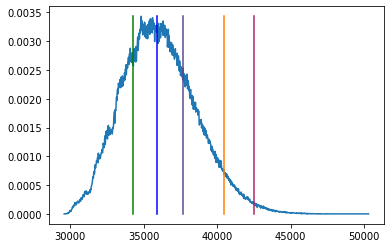

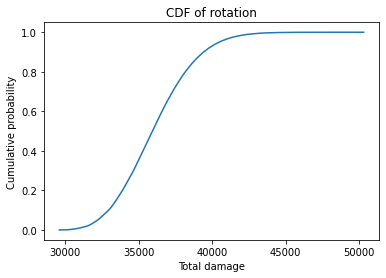

In [116]:
print('===Doing {class_to_sim} sim==='.format(class_to_sim=CLASS_TO_SIM))
start_time = time.time()

sim = Simulator(stats, rb.build(), debug=False)
total_damage, dps_tracker = sim.simulate()
end_time = time.time()

display_results(total_damage, fight_time)
print('Time taken: ' + str(end_time-start_time))

In [117]:
# # #@title normality test stuff. feel free to ignore

# import scipy.stats
# import statsmodels.api as sm

# mean = np.mean(total_damage)
# std = np.std(total_damage)
# gauss_samp = np.random.randn(1000000,)*std+mean

# print(scipy.stats.normaltest(total_damage))
# print(scipy.stats.normaltest(gauss_samp))

# def get_pdf(vals):  
#   count, bins_count = np.histogram(vals, bins=np.arange(np.min(total_damage),np.max(total_damage),(np.max(total_damage)-np.min(total_damage))/1000))
#   pdf = count / sum(count)
#   return bins_count, pdf

# bins_count, pdf = get_pdf(total_damage)
# bins_count_gauss, pdf_gauss = get_pdf(gauss_samp)

# plt.figure()
# plt.plot(bins_count[1:], pdf, label="PDF")
# plt.plot(bins_count_gauss[1:], pdf_gauss, label="PDF", color='g')
# plt.show()

# # sanity check
# print('total damage mean/std: {mean}/{std}'.format(mean=np.mean(total_damage), std=np.std(total_damage)))
# print('total damage mean/std: {mean}/{std}'.format(mean=np.mean(gauss_samp), std=np.std(gauss_samp)))

# plt.figure()
# sm.qqplot((total_damage-np.mean(total_damage))/np.std(total_damage), line='45')